In [3]:
import pandas as pd


Loading

In [4]:
df_parsed = pd.read_csv('../csv/BGL.csv')
entries_count = df_parsed.shape[0]
anomalies_count = df_parsed[df_parsed['Label']!='-'].shape[0]
anomalies_entries_ratio = anomalies_count/entries_count

In [5]:
df_aggregated= pd.read_csv('../csv/BGL-aggregated2.csv')
windows_count = df_aggregated.shape[0]
anomalous_windows_count = df_aggregated['Anomaly'].sum()
anomalous_windows_ratio = anomalous_windows_count/windows_count

Stats

In [6]:
print('Entries count :',entries_count)
print('Anomalies count :',anomalies_count)
print('Anomalies/entries rate :',round(anomalies_entries_ratio*100, 2),'%')

Entries count : 2615219
Anomalies count : 215528
Anomalies/entries rate : 8.24 %


In [7]:
df_parsed.head()

,Unnamed: 0,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,Template,Event
0,0,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.363779,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,instruction cache parity error corrected,E1
1,1,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.527847,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,instruction cache parity error corrected,E1
2,2,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,instruction cache parity error corrected,E1
3,3,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.823719,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,instruction cache parity error corrected,E1
4,4,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.982731,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,instruction cache parity error corrected,E1


In [8]:
print('Windows count (1-hour long, step of 5min) :',windows_count)
print('Anomalous windows count :', anomalous_windows_count)
print('Anomalous window rate :',round(anomalous_windows_ratio*100, 2),'%')

Windows count (1-hour long, step of 5min) : 61816
Anomalous windows count : 35893
Anomalous window rate : 58.06 %


In [9]:
df_aggregated.head()

,Unnamed: 0,Window Start,Window End,Anomaly,1,2,3,4,5,6,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
0,0,2005-06-03 15:42:50.363779,2005-06-03 16:42:50.363779,1,4863.0,14.0,10.0,65.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2005-06-03 15:47:50.363779,2005-06-03 16:47:50.363779,1,3236.0,22.0,15.0,78.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2005-06-03 15:52:50.363779,2005-06-03 16:52:50.363779,1,1660.0,16.0,15.0,78.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2005-06-03 15:57:50.363779,2005-06-03 16:57:50.363779,1,857.0,16.0,15.0,78.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2005-06-03 16:02:50.363779,2005-06-03 17:02:50.363779,1,0.0,16.0,14.0,77.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Modeling

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import pandas as pd

In [11]:
# Load the preprocessed
df = pd.read_csv('../csv/BGL-aggregated2.csv')

# Sort the data by Datetime to ensure it's time-ordered
df = df.sort_values(by='Window Start')

In [12]:
# 60 / 20 / 20
train_proportion = .6
val_proportion = .2
train_size = int(train_proportion * len(df))
val_size = int(val_proportion * len(df))
test_size = len(df) - train_size - val_size

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

In [13]:
X_train = train_df.drop(columns=['Window Start', 'Window End', 'Anomaly'])  # Features
y_train = train_df['Anomaly'].astype(int)  # Labels

X_val = val_df.drop(columns=['Window Start', 'Window End', 'Anomaly'])
y_val = val_df['Anomaly'].astype(int)

X_test = test_df.drop(columns=['Window Start', 'Window End', 'Anomaly'])
y_test = test_df['Anomaly'].astype(int)

In [14]:

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

In [15]:
# Train Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [ ]:
# Evaluation function
def evaluation(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    dico = {
        "accuracy":round(accuracy, 3), 
        "precision":round(precision, 3), 
        "AUC":round(auc, 3), 
        "recall":round(recall, 3)
        }
    return dico

random_forest_scores = evaluation(y_test, rf_pred)
logistic_reg_scores = evaluation(y_test, lr_pred)
# Evaluate each model on the test set
print(random_forest_scores)
print(logistic_reg_scores)

{'accuracy': 0.655, 'precision': 1.0, 'AUC': 0.646, 'recall': 0.293}
{'accuracy': 0.672, 'precision': 1.0, 'AUC': 0.664, 'recall': 0.328}


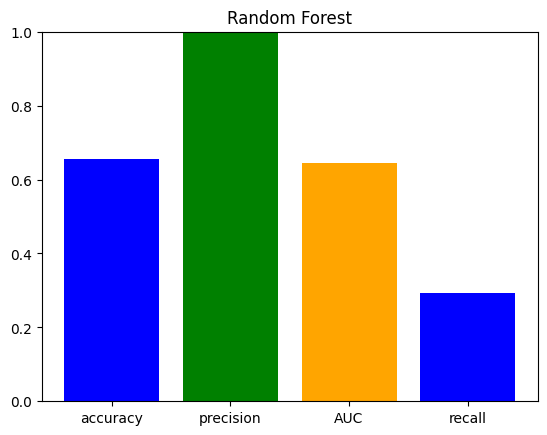

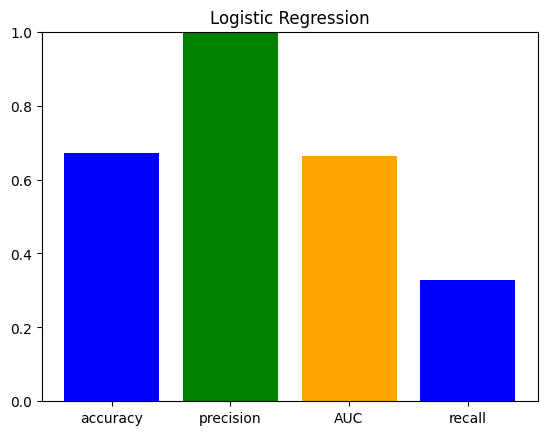

In [17]:
import matplotlib.pyplot as plt

def plotScores(scores: dict, name: str):
  categories = ['accuracy', 'precision','AUC','recall']
  valeurs = [scores[i] for i in categories]

  
  plt.bar(categories, valeurs, color=['blue', 'green', 'orange'])

  
  plt.title(name)
  plt.ylim(0, 1)

  
  plt.show()

plotScores(random_forest_scores, 'Random Forest')
plotScores(logistic_reg_scores, 'Logistic Regression')

In [35]:
events = [{"E0":"Template"}]
print(int(list(events[0].keys())[0][1:]))

0
